In [33]:
%matplotlib inline

import os
from skimage import data, io, filters
import scipy.ndimage as ndimage
from skimage import color, img_as_float

import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [30]:
class BBox(object):
    def __init__(self, x1, y1, x2, y2):
        '''
        (x1, y1) is the upper left corner,
        (x2, y2) is the lower right corner,
        with (0, 0) being in the upper left corner.
        '''
        if x1 > x2: x1, x2 = x2, x1
        if y1 > y2: y1, y2 = y2, y1
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2
    
    def width(self):
        return self.x2 - self.x1
    
    def height(self):
        return self.y2 - self.y1
    
    def x_extent(self):
        return self.x1 + self.width()

    def y_extent(self):
        return self.y1 + self.height()
    
    def extract(self, img):
        return img[(self.y1 - 1):self.y_extent(), (self.x1 - 1):self.x_extent(), :]

    
    def taxicab_diagonal(self):
        '''
        Return the taxicab distance from (x1,y1) to (x2,y2)
        '''
        return self.x2 - self.x1 + self.y2 - self.y1
    
    def overlaps(self, other):
        '''
        Return True iff self and other overlap.
        '''
        return not ((self.x1 > other.x2)
                    or (self.x2 < other.x1)
                    or (self.y1 > other.y2)
                    or (self.y2 < other.y1))
    
    def __eq__(self, other):
        return (self.x1 == other.x1
                and self.y1 == other.y1
                and self.x2 == other.x2
                and self.y2 == other.y2)

    
def slice_to_bbox(slices):
    for s in slices:
        dy, dx = s[:2]
        yield BBox(dx.start, dy.start, dx.stop+1, dy.stop+1)

        
def remove_overlaps(bboxes):
    '''
    Return a set of BBoxes which contain the given BBoxes.
    When two BBoxes overlap, replace both with the minimal BBox that contains both.
    '''
    # list upper left and lower right corners of the Bboxes
    corners = []

    # list upper left corners of the Bboxes
    ulcorners = []

    # dict mapping corners to Bboxes.
    bbox_map = {}

    for bbox in bboxes:
        ul = (bbox.x1, bbox.y1)
        lr = (bbox.x2, bbox.y2)
        bbox_map[ul] = bbox
        bbox_map[lr] = bbox
        ulcorners.append(ul)
        corners.append(ul)
        corners.append(lr)        

    # Use a KDTree so we can find corners that are nearby efficiently.
    tree = spatial.KDTree(corners)
    new_corners = []
    for corner in ulcorners:
        bbox = bbox_map[corner]
        # Find all points which are within a taxicab distance of corner
        indices = tree.query_ball_point(
            corner, bbox_map[corner].taxicab_diagonal(), p = 1)
        for near_corner in tree.data[indices]:
            near_bbox = bbox_map[tuple(near_corner)]
            if bbox != near_bbox and bbox.overlaps(near_bbox):
                # Expand both bboxes.
                # Since we mutate the bbox, all references to this bbox in
                # bbox_map are updated simultaneously.
                bbox.x1 = near_bbox.x1 = min(bbox.x1, near_bbox.x1)
                bbox.y1 = near_bbox.y1 = min(bbox.y1, near_bbox.y1) 
                bbox.x2 = near_bbox.x2 = max(bbox.x2, near_bbox.x2)
                bbox.y2 = near_bbox.y2 = max(bbox.y2, near_bbox.y2) 
    return set(bbox_map.values())

def remove_dups(bboxes):
    clean_set = []
    for bbox in bboxes:
        if bbox not in clean_set:
            clean_set.append(bbox)
    return clean_set

def find_squares(bboxes):
    return [bbox for bbox in bboxes if (bbox.width() > 30) and (bbox.width() < 50) and (bbox.height() > 30) and (bbox.height() < 50)]

In [31]:
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(5.5, 5.5, forward=True)

filename = '../out.jpg'


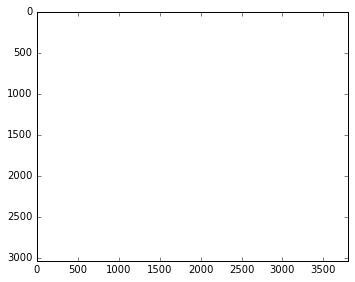

In [34]:
fimg = img_as_float(img)

filter_black = np.sum(fimg, axis=2)
fimg_bw = fimg.copy()
fimg_bw[(filter_black != 0)] = 1

io.imshow(fimg_bw)

In [35]:
fig = plt.figure()
i = 1
for icon in icons_filter:
    #ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(10,10,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(icon) 

NameError: name 'icons_filter' is not defined

7243


248

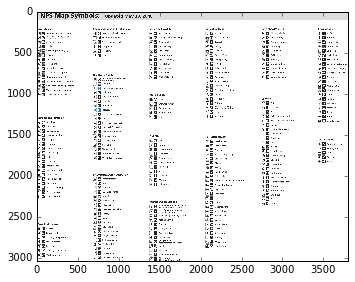

In [36]:
filename = "../data/map_symbols.jpg"
img = io.imread(filename, as_grey=False)


fimg = img_as_float(img)

filter_black = np.sum(fimg, axis=2)
fimg_bw = fimg.copy()
fimg_bw[(filter_black > 1)] = 1

io.imshow(fimg)

fimg_bw_one = fimg_bw[:,:,1]
fimg_bw_one_invert = 1 - fimg_bw_one

labels, numobjects = ndimage.label(fimg_bw_one_invert)
slices = ndimage.find_objects(labels)

bboxes = slice_to_bbox(slices)
#len(bboxes)
bboxes = remove_dups(bboxes)
print(len(bboxes))

bboxes_filter = find_squares(bboxes)
len(bboxes_filter)

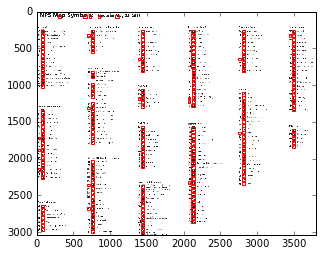

In [37]:
import matplotlib.patches as patches
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(fimg_bw)    
for bbox in bboxes_filter:
    xwidth = bbox.x2 - bbox.x1
    ywidth = bbox.y2 - bbox.y1
    p = patches.Rectangle((bbox.x1, bbox.y1), bbox.width(), bbox.height(),
                          fc = 'none', ec = 'red')
    ax.add_patch(p)

In [38]:
icons = [b.extract(fimg_bw) for b in bboxes_filter]

#icon_sums = [sum(np.sum(icon[:,:,1], axis=1)) for icon in icons]

In [6]:
#icons_filter = [icon for ind, icon in enumerate(icons) if icon_sums[ind] < 1100.0]
#len(icons_filter)

NameError: name 'icon_sums' is not defined

In [53]:
icons[1].shape

icon = icons[0]
shape = icon.shape
print(icon.shape)

print(icons[1].shape)
icon2 = icons[1][0:shape[0], 0:shape[1], :]
print(icon2.shape)

(43, 42, 3)
(43, 48, 3)
(43, 42, 3)


In [39]:
icons_sorted = sorted(icons, key=lambda x: sum(np.sum(x[:, :, 1], axis=1)))

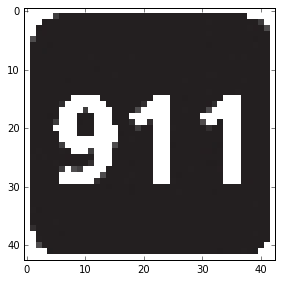

In [43]:
io.imshow(icons_sorted[0])

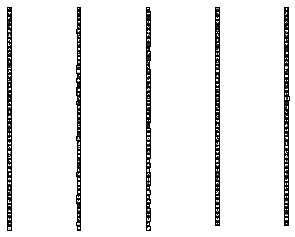

In [44]:
import math

fig = plt.figure()
width = 5
height = math.ceil(len(icons_sorted) / float(width))
#width = len(icons_filter) / 2
i = 1
for icon in icons_sorted:
    #ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(height,width,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(icon) 

In [47]:
label_width = 400
label_height = 50
tlabels = []
for bbox in bboxes_filter:
    label_box = BBox(bbox.x2, bbox.y1, bbox.x2 + label_width, bbox.y1 + label_height)
    #print(label_box.x1)
    tlabels.append(label_box.extract(fimg_bw))
len(tlabels)

248

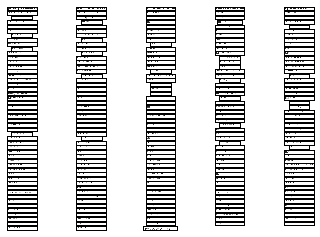

In [49]:
fig = plt.figure()
width = 5
height = math.ceil(len(icons_sorted) / float(width))
#width = len(icons_filter) / 2
i = 1
for icon in tlabels:
    #ddd = fimg_bw[b.y1:b.y_extent(), b.x1:b.x_extent(), :]
    ax = fig.add_subplot(height,width,i)
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1
    im = ax.imshow(icon) 